## Table of Contents

* 探索的データ分析・EDA
* よりたくさんの特徴を作る
    * 特徴量作成関数の構造について考える
    * 複数の値が紐づくテーブル情報を使う
    * テキスト系データの特徴量を作る
* つくった特徴量を定義する
* 新しい特徴量で学習する
    * 外れ値の影響を考える
* 質問に答えるコーナー

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib_venn import venn2

In [2]:
INPUT_DIR = '/analysis/data/tutorial/inputs/'
OUTPUT_DIR = '/analysis/data/tutorial/output_#2'

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from time import time

def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20
        
    return ' '.join([decoration, str(s), decoration])

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [4]:
import inspect

def param_to_name(params: dict, key_sep='_', key_value_sep='=') -> str:
    """
    dict を `key=value` で連結した string に変換します.
    Args:
        params:
        key_sep:
            key 同士を連結する際に使う文字列.
        key_value_sep:
            それぞれの key / value を連結するのに使う文字列.
            `"="` が指定されると例えば { 'foo': 10 } は `"foo=10"` に変換されます.
    Returns:
        文字列化した dict
    """
    sorted_params = sorted(params.items())
    return key_sep.join(map(lambda x: key_value_sep.join(map(str, x)), sorted_params))


def cachable(function):
    attr_name = '__cachefile__'
    def wrapper(*args, **kwrgs):
        force = kwrgs.pop('force', False)
        call_args = inspect.getcallargs(function, *args, **kwrgs)
        
        arg_name = param_to_name(call_args)
        name = attr_name + arg_name
        
        use_cache = hasattr(function, name) and not force
        
        if use_cache:
            cache_object = getattr(function, name)
        else:
            print('run')
            cache_object = function(*args, **kwrgs)
            setattr(function, name, cache_object)
            
        return cache_object
    
    return wrapper

In [5]:
@cachable
def read_csv(name):
    
    if '.csv' not in name:
        name = name + '.csv'
    
    return pd.read_csv(os.path.join(INPUT_DIR, name))

## 探索的データ分析・EDA

### Install Requirements

* https://github.com/pog87/PtitPrince を使います。連続値をカテゴリごとに見る時には box / boxen / violin などいくつかの方法があります。raincloud plot https://wellcomeopenresearch.org/articles/4-63/v2 で紹介された, これらを組み合わせて比較的わかりやすく可視化してくれる方法です。

!pip install ptitprince

> [ドメイン知識(西洋絵画とオランダの画家)](https://www.guruguru.science/competitions/16/discussions/14492ad2-fea7-4265-ba89-07a6b4d07d8b/)

こちらをもとに世紀ごとに like 数がどのように違っているかを見てみましょう。

In [7]:
from ptitprince import RainCloud

In [8]:
train_df = read_csv('train')
test_df = read_csv('test')

# わかりやすさのため底を 10 とした log 変換を行いました
train_df['log_likes'] = np.log10(train_df['likes'] + 1)

run
run


そもそも log をとった likes はどんな分布?

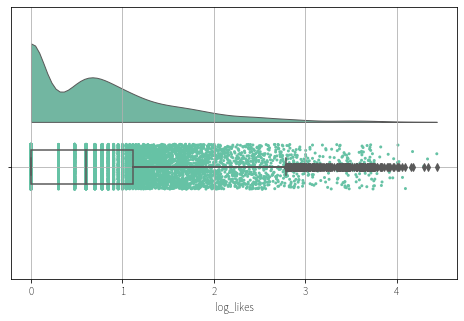

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
RainCloud(data=train_df, y='log_likes', orient='h', ax=ax)
ax.grid()

世紀ごとの良いね数分布

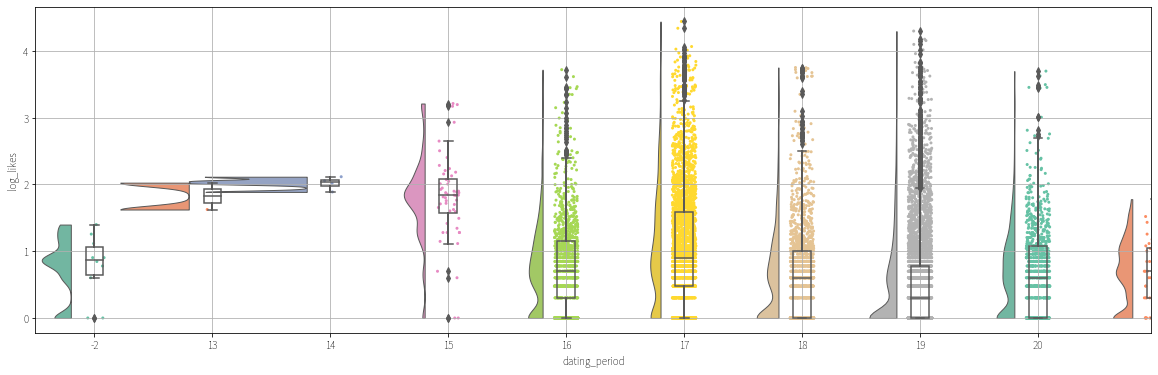

In [10]:
fig, ax = plt.subplots(figsize=(20, 6))
RainCloud(data=train_df, y='log_likes', x='dating_period', ax=ax, width_viol=2.)
ax.grid()

* どの時期も裾が広い分布で特定の世紀だけ変な分布になっているとかがあるわけではない。
    * しいて言うなら15世紀は中央にまとまっている印象。有名な絵画しかおいていないのかも。(具体的に見てみるのもよさそう)

第1回目で作ったモデルは subtitle の長さでよく分割していることがわかっています。流さごとに likes はどのようにかわっているでしょう。

In [11]:
sub_title_length = train_df['sub_title'].str.len().rename('subtitle_length')

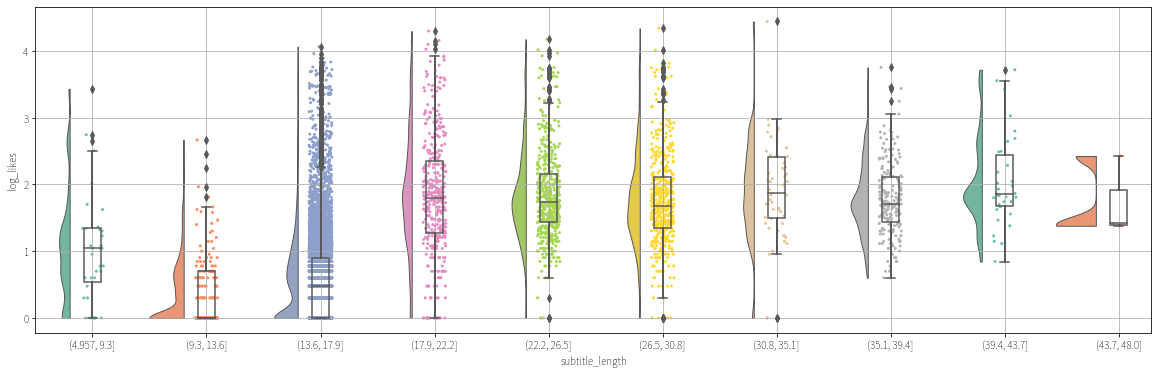

In [12]:
fig, ax = plt.subplots(figsize=(20, 6))
RainCloud(y=train_df['log_likes'], 
          x=pd.cut(sub_title_length, bins=10, duplicates='drop'), ax=ax)
ax.grid()

* 17文字あたりに壁があり、それを超えると一気にゼロが少なくなる

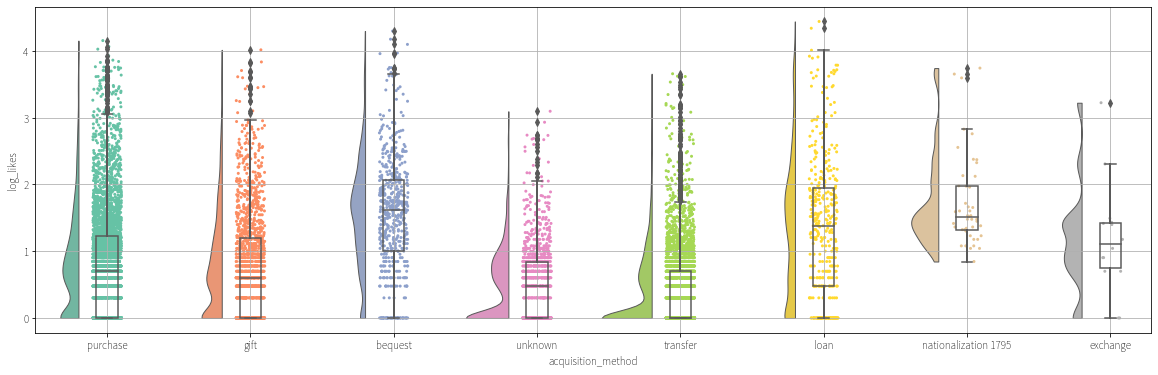

In [13]:
fig, ax = plt.subplots(figsize=(20, 6))
RainCloud(data=train_df, x='acquisition_method', y='log_likes', ax=ax)
ax.grid()

* bequest: 遺贈のものはゼロが少なく、中央値もとても高い. load / nationalization も高め.
* unknowwn / transfer は有名でないことが多い。(feature importance でも transfer は高めにでていましたね)

### 作家の影響

ナイーブに考えると、有名な作家がつくると全部有名な気がする。本当か?

In [14]:
x = train_df.groupby('principal_maker')['likes'].agg([
    'std', 'mean'
])

In [15]:
x.sort_values('std').dropna()

,std,mean
principal_maker,,
Paul Robert,0.000000,0.000000
Poulton,0.000000,0.000000
Ludovico Tuminello,0.000000,0.000000
Louis Surugue,0.000000,0.000000
Carlo Lasinio,0.000000,0.000000
...,...,...
Francesco Zugno,3930.099490,2793.000000
Jozef Israëls,5053.646851,1437.733333
Jan Asselijn,5421.454756,3980.500000


In [17]:
name = 'Rembrandt van Rijn' # レンブラント(夜警の人)
idx = train_df['principal_maker'] == name
train_df[idx].sort_values('likes')[['principal_maker', 'title', 'likes', 'dating_sorting_date']]

,principal_maker,title,likes,dating_sorting_date
1976,Rembrandt van Rijn,Bevrijding van Petrus uit de gevangenis,0,1635.0
1764,Rembrandt van Rijn,Jozef verklaart de dromen van de bakker en de ...,4,1616.0
2815,Rembrandt van Rijn,Heilige familie,4,1616.0
2911,Rembrandt van Rijn,Christus predikt,6,1616.0
5465,Rembrandt van Rijn,Buste van een man met tulband en baard,8,1616.0
1660,Rembrandt van Rijn,"Portrait of a man, perhaps Rembrandt's father,...",42,1730.0
1982,Rembrandt van Rijn,Laughing Young Man,130,1629.0
827,Rembrandt van Rijn,Portret van Rembrandt Harmensz. van Rijn,278,1640.0
966,Rembrandt van Rijn,Salome ontvangt het hoofd van Johannes de Doper,387,1640.0
3314,Rembrandt van Rijn,Portrait of Ephraim Bueno,906,1645.0


* めちゃ有名な人だからといってすべての作品が likes が多いとはかぎらない. 
    * → 何が差分の要素なのかをデータを眺めて考えてみる。切り出してエクセルで見る。

## よりたくさんの特徴量の作成

### 特徴量作成関数の構造

第一回目では関数形式での実装方法をお伝えしました。関数形式でも問題はないのですが、少し不満があります。それは学習時とテスト時で同じ用な計算をしなくてはならない、という点です。

例えば CountEncoding のコードを思い出しましょう。CountEncoding は出現回数の計算を行なう必要がありますが、テストデータやあるいは新しい別のデータに対して CountEncoding する場合には、過去に計算したカウント情報を使って単に変換だけを行なうべきでしょう。(#1でやった方法では学習・推論で二回カウント計算が走っていることに注意してください。) このように機械学習の特徴量変換は

1. 学習時に内部状態を記憶しておいて
2. 推論時には `1` でつくった情報を用いて変換をする

という構造をもっていることが非常に多いです(これは機械学習モデル自体も同様の構造ですね)。ですのでこの論理的な構造をコードにも反映して行きたいと思います。

### AbstractBaseBlock

具体的には、状態管理のために Class をつかった実装を使いたいと思います。Classといってもとても自然な形式をしていて学習フェーズ fit と推論フェーズ tarnsform があるだけです。推論はどの特徴変換でも必須ですので実装が強制されています。(NotImplementedErrorになる)

内部状態を変更するような場合には fit も実装して, インスタンスの attribute として保存するという流れです。

In [20]:
class AbstractBaseBlock:
    def fit(self, input_df: pd.DataFrame, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()

### 内部状態更新が行われない例

入力される変換元のデータに含まれる情報を加工して取り出すような特徴量は内部状態が必要ありませんので transform のみを定義すればよいです。例えば `dating_sorting_date` をそのまま使う場合などですね。

In [21]:
class NumericBlock(AbstractBaseBlock):
    def transform(self, input_df):
        use_columns = [
            'dating_period',
            'dating_year_early',
            'dating_year_late'
        ]
        
        return input_df[use_columns].copy()

また文字列とみなして長さを計算するもの (StringLength) も、単に計算しているだけなので内部状態は不要です。

In [23]:
class StringLengthBlock(AbstractBaseBlock):
    def __init__(self, column):
        self.column = column
    
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].str.len()
        return out_df.add_prefix('StringLength_')

### 内部状態が更新される例・ CountEncoding

データの中で何回その値が出現するかに置き換える方法が CountEncoding です。例えば [0, 0, 1, 0, 2] という配列があったとすると 0 は3回, 1, 2 は1回出現しますから [3, 3, 1, 3, 1] となります。このようにデータをその出てきた回数の観点で見るのが CountEncoding です。

CountEncoding は出現回数を数えるという内部状態の更新が必要ですので fit で回数を計算します。

In [26]:
def read_whole_df():
    return pd.concat([
        read_csv('train'), read_csv('test')
    ], ignore_index=True)

class CountEncodingBlock(AbstractBaseBlock):
    """CountEncodingを行なう block"""
    def __init__(self, column: str):
        self.column = column

    def fit(self, input_df, y=None):
#         vc = input_df[self.column].value_counts()
        master_df = read_whole_df()
        vc = master_df[self.column].value_counts()
        self.count_ = vc
        return self.transform(input_df)

    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].map(self.count_)
        return out_df.add_prefix('CE_')

One Hot Encoding も同様に「どの集合を category の対象とみなすか」を内部状態として保持する必要があります。

In [30]:
class OneHotEncoding(AbstractBaseBlock):
    def __init__(self, column, min_count=30):
        self.column = column
        self.min_count = min_count
        
    def fit(self, input_df, y=None):
        x = input_df[self.column]
        vc = x.value_counts()
        categories = vc[vc > self.min_count].index
        self.categories_ = categories
        
        return self.transform(input_df)
    
    def transform(self, input_df):
        x = input_df[self.column]
        cat = pd.Categorical(x, categories=self.categories_)
        out_df = pd.get_dummies(cat)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'{self.column}=')

In [34]:
block = OneHotEncoding('principal_maker', min_count=40)

この辺を用意しておくと脳死でたくさん特徴量は作れます

In [42]:
feature_blocks = [
    *[OneHotEncoding(c, min_count=20) for c in ['title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],
    *[CountEncodingBlock(c) for c in ['art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],
    *[StringLengthBlock(c) for c in [
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
    ]]
]

In [43]:
def run_blocks(input_df, blocks, y=None, test=False):
    out_df = pd.DataFrame()
    
    print(decorate('start run blocks...'))

    with Timer(prefix='run test={}'.format(test)):
        for block in feature_blocks:
            with Timer(prefix='\t- {}'.format(str(block))):
                if not test:
                    out_i = block.fit(input_df, y=y)
                else:
                    out_i = block.transform(input_df)

            assert len(input_df) == len(out_i), block
            name = block.__class__.__name__
            out_df = pd.concat([out_df, out_i.add_suffix(f'@{name}')], axis=1)
        
    return out_df

In [44]:
run_blocks(train_df, blocks=feature_blocks)
run_blocks(test_df, blocks=feature_blocks, test=True)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	- <__main__.OneHotEncoding object at 0x7fe5c0983110> 0.007[s]
	- <__main__.OneHotEncoding object at 0x7fe5c09831d0> 0.006[s]
	- <__main__.OneHotEncoding object at 0x7fe5c0983190> 0.006[s]
	- <__main__.OneHotEncoding object at 0x7fe5c0983150> 0.005[s]
	- <__main__.OneHotEncoding object at 0x7fe5c0983210> 0.006[s]
	- <__main__.OneHotEncoding object at 0x7fe5c0983350> 0.006[s]
	- <__main__.OneHotEncoding object at 0x7fe5c0983390> 0.003[s]
	- <__main__.OneHotEncoding object at 0x7fe5c09833d0> 0.006[s]
	- <__main__.OneHotEncoding object at 0x7fe5c0983410> 0.004[s]
	- <__main__.OneHotEncoding object at 0x7fe5c0983310> 0.005[s]
	- <__main__.OneHotEncoding object at 0x7fe5c0983450> 0.004[s]
	- <__main__.OneHotEncoding object at 0x7fe5c0983490> 0.006[s]
	- <__main__.OneHotEncoding object at 0x7fe5c09834d0> 0.004[s]
	- <__main__.OneHotEncoding object at 0x7fe5c0983510> 0.001[s]
	- <__main__.OneHotEncoding object at 0x7fe5c0983550> 0.

,title=Portret van een onbekende vrouw@OneHotEncoding,title=Portret van een onbekende man@OneHotEncoding,title=Portrait of a Man@OneHotEncoding,title=Portret van een onbekende jonge vrouw@OneHotEncoding,title=Portret van een vrouw@OneHotEncoding,description=Deze foto maakt deel uit van een album.@OneHotEncoding,description=Onderdeel van Album met foto's van bezienswaardigheden en landschappen in Engeland en van kunst.@OneHotEncoding,"description=Onderdeel van Engels familiealbum met foto's van personen, reizen, cricket en kunstwerken.@OneHotEncoding",description=Deze prent maakt deel uit van een album.@OneHotEncoding,description=Onderdeel van fotoalbum overstroming Parijs en voorsteden 1910.@OneHotEncoding,...,CE_dating_sorting_date@CountEncodingBlock,CE_dating_period@CountEncodingBlock,CE_dating_year_early@CountEncodingBlock,CE_dating_year_late@CountEncodingBlock,StringLength_title@StringLengthBlock,StringLength_description@StringLengthBlock,StringLength_long_title@StringLengthBlock,StringLength_principal_maker@StringLengthBlock,StringLength_principal_or_first_maker@StringLengthBlock,StringLength_sub_title@StringLengthBlock
0,0,0,0,0,0,0,0,0,0,0,...,458.0,10135,458.0,765.0,51,NaN,84,18,18,17.0
1,0,0,0,0,0,0,0,0,0,0,...,45.0,6022,45.0,128.0,59,230.0,120,26,26,19.0
2,0,0,0,0,0,0,0,0,0,0,...,32.0,3247,32.0,82.0,36,97.0,59,15,15,17.0
3,0,0,0,0,0,0,0,0,0,0,...,266.0,10135,266.0,380.0,64,309.0,100,21,21,17.0
4,0,0,0,0,0,0,0,0,0,0,...,203.0,6022,203.0,100.0,52,334.0,70,10,10,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12003,0,0,0,0,0,0,0,0,0,0,...,148.0,10135,148.0,148.0,30,NaN,52,14,14,15.0
12004,0,0,0,0,0,0,0,0,0,0,...,298.0,10135,298.0,361.0,126,36.0,180,23,23,17.0
12005,0,0,0,0,0,0,0,0,0,0,...,107.0,10135,107.0,83.0,33,NaN,61,13,13,11.0
12006,0,0,0,0,0,0,0,0,0,0,...,148.0,10135,148.0,148.0,35,NaN,57,14,14,15.0


## 外部のテーブル情報を使う

> 複数の値が紐づくテーブル同士をどうマージするのが良いか悩んでいるので、そのあたりの考え方など扱っていただけると嬉しいです！

In [45]:
person_df = read_csv('historical_person')

run


In [49]:
person_df.head()

,object_id,name
0,00133be3ff222c9b74b0,Staten-Generaal
1,00133be3ff222c9b74b0,"Álvarez de Toledo, Fernando (3e hertog van Alva)"
2,0026e030a0209b834b3e,Raad van Beroerten
3,0026e030a0209b834b3e,"Álvarez de Toledo, Fernando (3e hertog van Alva)"
4,00440ec5a4783b4b6bdb,Dolle Mina


In [50]:
data = pd.DataFrame({
    'a': [1, 2, 2, 2, 3, 3],
    'b': [0, 1, 0, 1, 1, 1]
})

In [51]:
data

,a,b
0,1,0
1,2,1
2,2,0
3,2,1
4,3,1
5,3,1


In [52]:
pd.crosstab(data['a'], data['b'])

b,0,1
a,,
1,1,0
2,1,2
3,0,2


material に適用すると `object_id` を列にもつようなテーブルを作れます. これを art_object table に left join すれば「どんな material をもっているか」という情報にすることができます。

In [53]:
pd.crosstab(person_df['object_id'], person_df['name'])

name,"Aaninck, Theodorus",Aarnout (graaf van Holland),"Abba, Clara",Abel Tasman (schip),"Abrahamsz., Cornelis","Abresch, Petrus","Abélard, Pierre","Acevedo, Pedro Enríquez de (Count of Fuentes)","Achtienhoven, C.F.","Acquoy, Johannes Gerhardus Rijk",...,"Zoutman, Johan Arnold","Zuylen van Nijevelt, Theodora van","Zuñiga y Fonseca, Juan Domingo de (graaf van Monterey)","Zwaardecroon, Henricus","Zwemmer, Nelletje","Zwijndregt, Leonardus van","Zwijsen, Johannes","Zúñiga y Requesens, Luis de",hertogin van Chartres,"Álvarez de Toledo, Fernando (3e hertog van Alva)"
object_id,,,,,,,,,,,,,,,,,,,,,
00133be3ff222c9b74b0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0026e030a0209b834b3e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
00440ec5a4783b4b6bdb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
005143d648d06d8adde3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
007898ec2976b7da6a03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffe646a5514da84e9864,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffeb384305262f3500f5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffedf8af4fd5b3873164,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


ただこの方法には問題点があり、それは `name` のユニーク数分だけ列数が必要となる点です。(OneHot化しているようなものなのでしようがないですね)
避ける方法の一つとして最小出現回数で絞り込みをかける、という方法があります。具体的には以下のような形ですね。

In [54]:
vc = person_df['name'].value_counts()

# 出現回数30以上に絞る
use_names = vc[vc > 30].index

# isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
idx = person_df['name'].isin(use_names)
_use_df = person_df[idx].reset_index(drop=True)
pd.crosstab(_use_df['object_id'], _use_df['name'])

name,"Djatiroto, Suikeronderneming",Frederik Hendrik (prins van Oranje),Handels Vereeniging Amsterdam,Jacobus II (koning van Engeland en Schotland),Lodewijk XIV (koning van Frankrijk),"Maria II Stuart (koningin van Engeland, Schotland en Ierland)",Maurits (prins van Oranje),"Musschenbroek, Sam van","Oldenbarnevelt, Johan van","Titzenthaler, Eckart",...,Wehrmacht,Wilhelm II (keizer van Duitsland),Wilhelmina (koningin der Nederlanden),Willem I (prins van Oranje),Willem III (koning der Nederlanden),"Willem III (prins van Oranje en koning van Engeland, Schotland en Ierland)","Wirix, F.J.","Witt, Cornelis de","Witt, Johan de","Álvarez de Toledo, Fernando (3e hertog van Alva)"
object_id,,,,,,,,,,,,,,,,,,,,,
00133be3ff222c9b74b0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0026e030a0209b834b3e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
009d44bd779a8722b00c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
00cd543929cbd97be573,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00d601332278b5dad17e,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff4e08fb9e8887bbe1a3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ff657e8134633815bf1d,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
ff7b9c0a4a4cbaa7f7db,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
OBJECT_ID = 'object_id'

In [56]:
def left_join(left, right, on=OBJECT_ID):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])

In [58]:
class HistoricalPersonBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count
    
    def fit(self, input_df, y=None):
        person_df = read_csv('historical_person')
        
        vc = person_df['name'].value_counts()
        # 出現回数30以上に絞る
        use_names = vc[vc >= self.min_count].index

        # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
        idx = person_df['name'].isin(use_names)
        _use_df = person_df[idx].reset_index(drop=True)
        
        self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'HistoricalPersonBlock_name=')

In [59]:
block = HistoricalPersonBlock()

assert len(block.fit(train_df)) == len(train_df)
assert block.transform(test_df).equals(block.transform(test_df))

### 一般化する

上記の例は historical person に絞ったやり方ですが、データ構造を見ているとその他のテーブルも似たような構造を持っていることがわかります。これらのテーブルも同じようなことをすると特徴量として追加できそうですね。

### ベン図で分布がずれているか確認する

今作った historical person の名前の分布が train / test であまりかけ離れているとこまります。これを確認するために train に現れる name と test にあ笑われる name がどのぐらい被っているのかをベン図で可視化してみます。

In [60]:
def filter_names(master_df: pd.DataFrame, input_df: pd.DataFrame) -> set:
    idx = master_df['object_id'].isin(input_df['object_id'])
    return set(master_df[idx]['name'].unique())

Text(0.5, 1.0, 'Historical Person の分布')

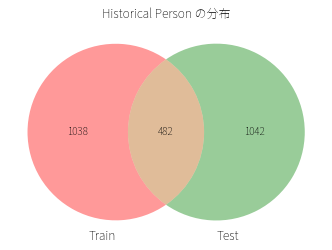

In [61]:
fig, ax = plt.subplots(figsize=(6, 4))
venn2(subsets=(filter_names(person_df, train_df), 
               filter_names(person_df, test_df)), set_labels=('Train', 'Test'), ax=ax)
ax.set_title('Historical Person の分布')

ちょっと一般化してみましょう。

In [62]:
def plot_one2many_relation_table_intersection(name: str, ax: plt.Axes) -> plt.Axes:
    master_df = read_csv(name)
    venn2(subsets=(filter_names(master_df, train_df), filter_names(master_df, test_df)), 
          set_labels=('Train', 'Test'), 
          ax=ax, 
          set_colors=('C0', 'C1'))
    ax.set_title(f'{name}の分布')
    return ax

run


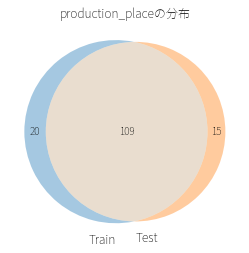

In [63]:
fig, ax = plt.subplots()
plot_one2many_relation_table_intersection('production_place', ax)

In [64]:
table_names = [
    'production_place',
    'material',
    'object_collection',
    'historical_person',
    'technique'
]

run
run
run


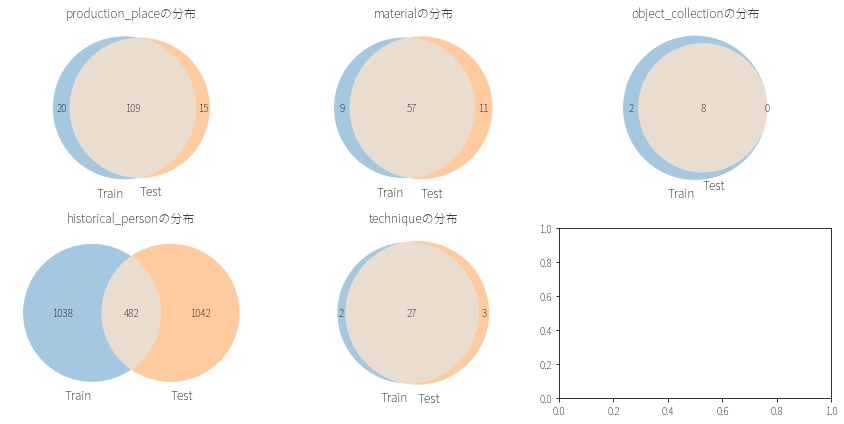

In [65]:
n_figs = len(table_names)
n_cols = 3
n_rows = - (- n_figs // n_cols)

fig, axes = plt.subplots(figsize=(4 * n_cols, 3 * n_rows), ncols=n_cols, nrows=n_rows)
axes = np.ravel(axes)

for name, ax in zip(table_names, axes):
    plot_one2many_relation_table_intersection(name=name, ax=ax)
    
fig.tight_layout()

!pip install mlxtend

In [67]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

target_df = read_csv('material')
df = pd.crosstab(target_df['object_id'], target_df['name'])

In [69]:
freq_item_df = apriori(df, min_support=.005, use_colnames=True)
freq_item_df.sort_values('support', ascending=False)

,support,itemsets
9,0.561816,(paper)
10,0.322861,(photographic paper)
7,0.175146,(oil paint (paint))
2,0.172730,(cardboard)
14,0.153947,"(cardboard, photographic paper)"
20,0.104766,"(paper, photographic paper)"
1,0.094124,(canvas)
12,0.093445,"(canvas, oil paint (paint))"
8,0.071865,(panel)
19,0.069575,"(panel, oil paint (paint))"


In [ ]:
association_rules(freq_item_df, metric='lift').sort_values('lift', ascending=False)
sns.clustermap(df.corr(), cmap='Blues')

### テキスト系データの取り扱い

テキスト系データが多くって困っている人が多いと思います。今までは文字列の長さだけに注目していましたが、もうちょっとふかぼって特徴量として使える方法を考えていきます。

#### 参考になるディスカッション

kaerururu-san の disucussion では BERT を使う方法が紹介されていました。https://www.guruguru.science/competitions/16/discussions/fb792c87-6bad-445d-aa34-b4118fc378c1/ 

この講座では、もうちょっとふるい方法ですがそれなりにワークする TFIDF と呼ばれる方法を紹介していきたいと思います。

#### TFIDFとは

TFIDF は文章ごとの単語の出現回数 (TermFrequency: tf) を文章集合での希少度 (inverse document frequency: idf) でかけ合わせて文章の特徴量とするものです。単語をカウントするだけの BoW: bag of word の発展形という位置付けです。

基本はカウントしているだけなのでとても単純ですが、事前学習などが不要で手軽に試せるうえ場合によってはなかなか性能がでる手法ですし計算量もしれていて、ベースラインとしては最適です。

#### 前処理

テキスト系データは分析には適さない文字や単語が含まれています。例えば文章の意味分析をする上では英語で言う前置詞やよくでてくる `I`, `you` といった単語はなんにでも出てくるため、文章の意味情報には大きな影響を与えないでしょう。こういった単語を取り除く作業を行ったり、記号や数字を取り除く、大文字小文字をすべて小文字にする、など文章を「機械から見た時に綺麗にする」処理を行なうことを「前処理」と言います。

とくに TFIDF のようにカウントベースの特徴は表記ゆれに弱く (活用形などで少しでも表現がずれると別のものとされてしまう)、また一般的に出てくるワードもカウントしてしまいノイズになりやすいですので、前処理は行ったほうが良いです。

自分で正規表現など書いても良いですがそれなりに大変なためライブラリの力を借りましょう。今回は `texthero` を紹介したいと思います。texthero は自然言語処理 (NLP) の前処理などを行なうためのライブラリです。

https://github.com/jbesomi/texthero

In [ ]:
!pip install texthero

In [71]:
import texthero as hero

texthero には, 前処理のための method がいくつか用意されています。今回は公式で定義されている以下の処理を使っていきます。

* https://texthero.org/docs/api/texthero.preprocessing.clean

In [72]:
raw_text = train_df['description']

clean_text = hero.clean(raw_text, pipeline=[
    hero.preprocessing.fillna,
    hero.preprocessing.lowercase,
    hero.preprocessing.remove_digits,
    hero.preprocessing.remove_punctuation,
    hero.preprocessing.remove_diacritics,
    hero.preprocessing.remove_stopwords
])

/home/penguin/.conda/lib/python3.7/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/penguin/.conda/lib/python3.7/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


In [74]:
# これがこうなる
i = 101
print('{} \n-> {}'.format(raw_text.values[i], clean_text.values[i]))

Berglandschap met een waterval tussen rotsen en boomstammen. De rivier stroomt door een dal tussen twee bergen waarop kastelen staan. 
-> berglandschap met een waterval tussen rotsen en boomstammen  de rivier stroomt door een dal tussen twee bergen waarop kastelen staan 


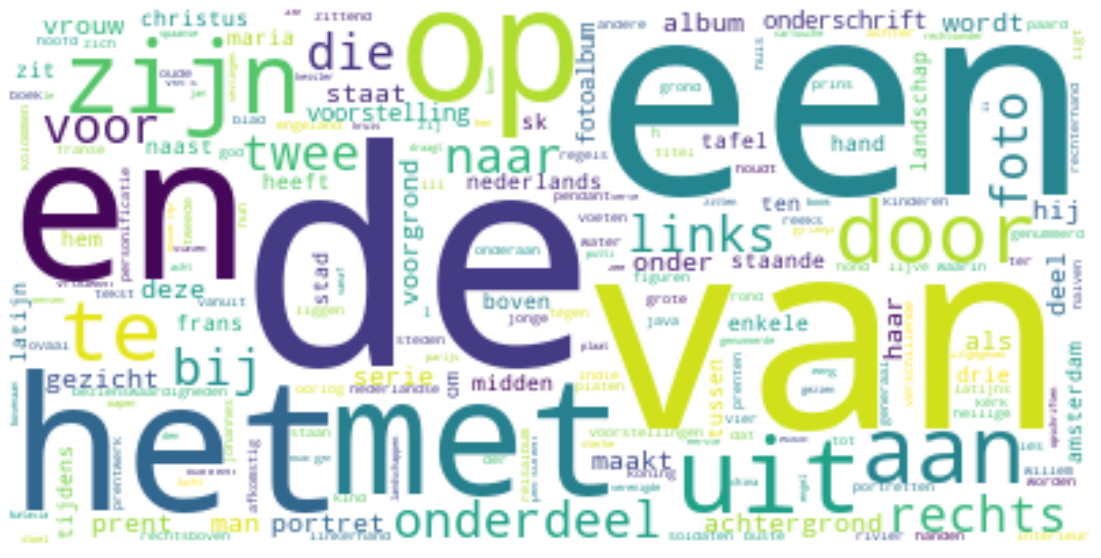

In [75]:
hero.visualization.wordcloud(clean_text, colormap='viridis', background_color='white')

なるほどよくわかりませんが、短い単語 (de / en など) がいくつもあってなんとなく前置詞とかの意味をなさない単語のように見えますね。discussion でもあがっていましたが text はオランダ語である場合があります。オランダ語での stopword も考慮するように少し直します。

In [76]:
import nltk

nltk.download('stopwords')
os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/penguin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['arabic',
 'greek',
 'azerbaijani',
 'indonesian',
 'nepali',
 'slovene',
 'romanian',
 'spanish',
 'swedish',
 'turkish',
 'russian',
 'french',
 'german',
 'kazakh',
 'README',
 'tajik',
 'dutch',
 'danish',
 'hungarian',
 'finnish',
 'english',
 'italian',
 'norwegian',
 'portuguese']

In [77]:
# 英語とオランダ語を stopword として指定
custom_stopwords = nltk.corpus.stopwords.words('dutch') + nltk.corpus.stopwords.words('english')

apply_stopword_text = hero.clean(raw_text, pipeline=[
    hero.preprocessing.fillna,
    hero.preprocessing.lowercase,
    hero.preprocessing.remove_digits,
    hero.preprocessing.remove_punctuation,
    hero.preprocessing.remove_diacritics,
    lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
])

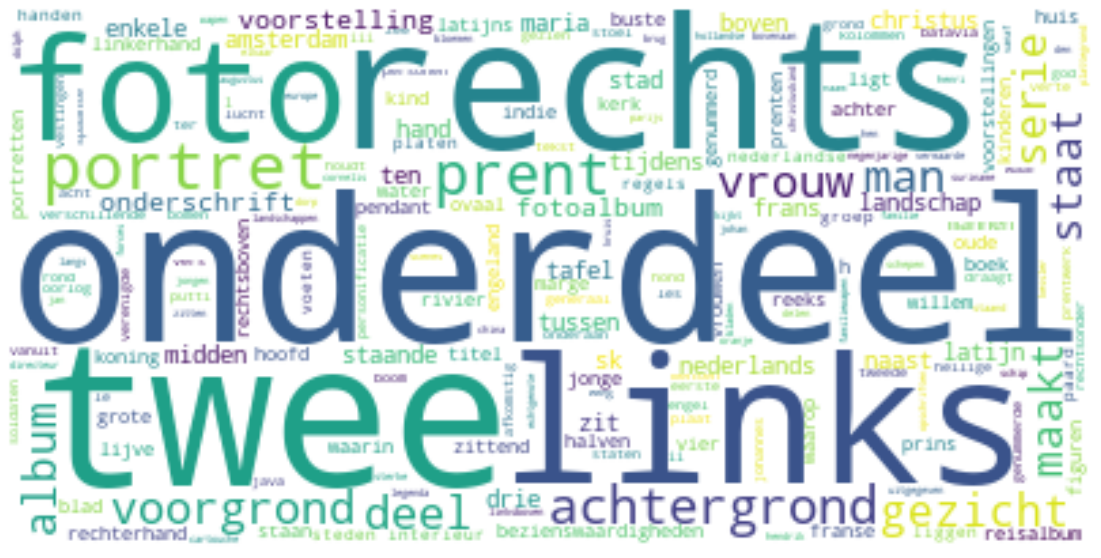

In [78]:
hero.visualization.wordcloud(apply_stopword_text, colormap='viridis', background_color='white')

僕はオランダ語わかりませんが portret (ポートレイト・肖像画) や foto (写真) などが見て取れます。先ほどより前置詞のような単語が表に出てこなくなっていることが確認できます。

### 特徴量へ変換 / Tfidf

古典的ですが強力な tfidf をつかって特徴へ変換します。

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

In [86]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100000)),
    ('svd', TruncatedSVD(n_components=50)),
])

z = pipeline.fit_transform(apply_stopword_text)

#### 特徴量の可視化

低次元に射影して、特徴量がターゲットの説明になっていそうかを見てみます。今回可視化のために T-SNE をつかいます。scikit-learn にも実装がありますが早くないので別のライブラリの実装を使います。

In [87]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# tsneおそいのでちょっと時間かかる
with Timer(prefix='run tsne'):
    tsne = TSNE(n_jobs=-1)
    embedding = tsne.fit_transform(z)

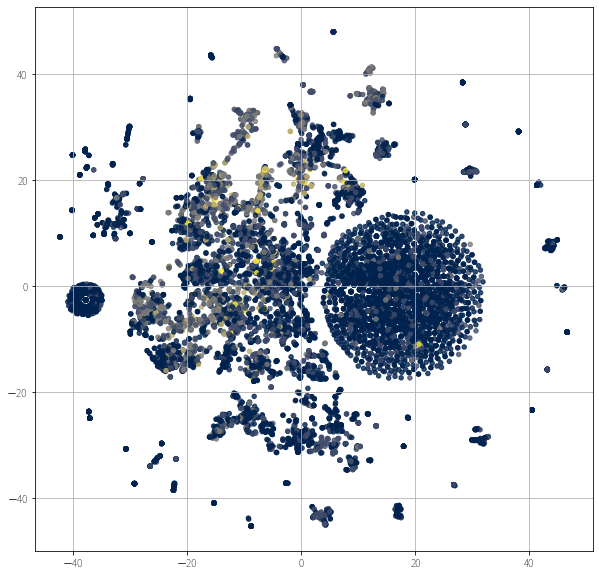

In [89]:
bin_labels = pd.cut(train_df['log_likes'], bins=5)
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(*embedding.T, c=bin_labels.cat.codes, s=20, alpha=.8, cmap='cividis')
ax.grid()

色が明るいほうが like が大きい物。ちいさいのと大きいのとで分離できていそうですね。

### Tfidf Block

tdfid 特徴量を作る block を実装します。

In [90]:
def text_normalization(text):
    
    # 英語とオランダ語を stopword として指定
    custom_stopwords = nltk.corpus.stopwords.words('dutch') + nltk.corpus.stopwords.words('english')

    x = hero.clean(text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])
    
    return x

class TfidfBlock(AbstractBaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
    
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
    
    def get_master(self, input_df):
        """tdidfを計算するための全体集合を返す. 
        デフォルトでは fit でわたされた dataframe を使うが, もっと別のデータを使うのも考えられる."""
        return input_df
    
    def fit(self, input_df, y=None):
        master_df = self.get_master(input_df)
        text = self.preprocess(input_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=10000)),
            ('svd', TruncatedSVD(n_components=50)),
        ])
        
        self.pileline_.fit(text)
        return self.transform(input_df)
    
    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)
        
        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'{self.column}_tfidf_')

In [91]:
block = TfidfBlock('title')

In [92]:
block.fit(train_df)

assert block.transform(train_df).equals(block.transform(train_df))
assert block.transform(test_df).equals(block.transform(test_df))

/home/penguin/.conda/lib/python3.7/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/penguin/.conda/lib/python3.7/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/penguin/.conda/lib/python3.7/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/penguin/.conda/lib/python3.7/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


,title_tfidf_0,title_tfidf_1,title_tfidf_2,title_tfidf_3,title_tfidf_4,title_tfidf_5,title_tfidf_6,title_tfidf_7,title_tfidf_8,title_tfidf_9,...,title_tfidf_40,title_tfidf_41,title_tfidf_42,title_tfidf_43,title_tfidf_44,title_tfidf_45,title_tfidf_46,title_tfidf_47,title_tfidf_48,title_tfidf_49
0,4.378734e-07,0.000006,6.414938e-06,0.000012,0.000013,0.000031,0.000057,0.000143,0.000005,-0.000136,...,-0.001267,0.000848,-0.000121,0.001791,-0.000310,-0.001112,-0.000523,0.000378,-0.001130,0.000710
1,5.628100e-04,-0.000868,6.232317e-04,0.000650,0.001004,-0.000187,0.002336,-0.001180,-0.000013,0.000299,...,0.002984,0.000975,0.001876,-0.001794,-0.001166,0.001850,0.006000,0.000199,-0.006741,0.008249
2,7.148147e-01,-0.397930,2.550704e-02,0.245002,0.189265,-0.134237,0.360969,-0.138368,-0.000860,0.024831,...,0.005997,0.009117,0.001764,-0.012395,-0.005446,0.003991,-0.008587,-0.004221,-0.008807,0.017430
3,8.928369e-04,0.001896,1.901109e-03,0.000218,0.004391,0.000161,0.001762,0.000111,0.002930,-0.000448,...,-0.029183,-0.015052,0.001684,-0.019582,-0.025067,0.002431,-0.014129,0.005096,0.010104,0.008526
4,1.877142e-04,0.000538,9.739730e-03,-0.000771,0.000722,0.014905,0.003407,-0.004023,-0.000256,0.003984,...,-0.094071,-0.047150,0.019080,-0.035804,0.018251,0.115015,-0.002632,-0.078736,-0.023219,0.007905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,4.488159e-03,-0.000339,2.475950e-04,-0.008512,0.020920,-0.001896,0.002775,-0.001162,-0.000167,-0.000058,...,0.000674,0.015032,-0.000484,-0.006858,-0.005703,0.006884,0.012931,0.015900,0.019762,0.002469
12022,5.199923e-04,0.000151,6.907751e-03,0.000694,0.002652,0.025935,0.041021,0.107204,-0.002040,0.168337,...,-0.011704,-0.019088,0.000896,-0.046639,0.055704,0.026457,0.027239,0.004497,-0.065727,-0.045653
12023,6.596016e-04,0.007999,4.199188e-02,0.014357,0.013742,0.043966,0.082348,0.215297,0.000545,-0.168405,...,-0.003607,-0.007250,0.004527,-0.024377,0.019489,0.026929,-0.002850,-0.002439,0.003612,-0.001214
12024,2.942192e-04,0.001386,1.933601e-02,0.000362,0.005844,0.045812,0.113787,0.354769,-0.006716,0.547451,...,-0.017716,-0.041640,0.008943,-0.114793,0.113664,0.075808,0.066653,-0.011356,-0.101741,-0.090932


#### より高度なテキスト特徴量

アルゴリズムには詳しく触れませんでしたが、単純な割には強力な特徴量ですが、回数しか考えないため, 単語同時の前後関係など並びを考慮した意味情報などは捉えることができません。

それらを考えたアルゴリズムも提案されていて最も有名なものが Word2Vec・fasttext・GloVE などの word embedding 手法です。更には最近では BERT などの transformer をつかった特徴量もあります。気になった方はこれらを調べてみると良いでしょう。

## つくった特徴量を定義する

In [94]:
feature_blocks = [
    # one hot encoding
    *[OneHotEncoding(c) for c in [
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],
    
    # count encoding
    *[CountEncodingBlock(c) for c in [
        'art_series_id', 
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],
    
    # 文字列長さ
    *[StringLengthBlock(c) for c in [
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
    ]],
    # historical person
    HistoricalPersonBlock(),
    
    # description の tfidf
    TfidfBlock('description')
]

train_feat_df = run_blocks(train_df, blocks=feature_blocks, test=False)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	- <__main__.OneHotEncoding object at 0x7fe51008d690> 0.007[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d6d0> 0.006[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d710> 0.006[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d650> 0.005[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d550> 0.005[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d4d0> 0.006[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d490> 0.004[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d450> 0.006[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d410> 0.004[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d510> 0.005[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d3d0> 0.004[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d390> 0.005[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d350> 0.003[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d310> 0.001[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d2d0> 0.

/home/penguin/.conda/lib/python3.7/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/penguin/.conda/lib/python3.7/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/penguin/.conda/lib/python3.7/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/penguin/.conda/lib/python3.7/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


	- <__main__.TfidfBlock object at 0x7fe512b3ddd0> 4.393[s]
run test=False 4.813[s]


In [95]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from typing import Union, Optional, Iterable

def fit_lgbm(X: np.ndarray, 
             y: np.ndarray, 
             cv: Iterable, 
             y_max: Optional[float] = None,
             params: Optional[dict] = None, 
             verbose: Optional[int] =50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}
    is_silent = verbose is None
    is_cut_y = y_max is not None
        
    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=np.float)
    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        # 最大値が決まっている場合, 学習するデータだけ丸めを行なう
        if is_cut_y:
            idx_use = y_train < y_max
            y_train = np.where(idx_use, y_train, y_max)
        clf = lgbm.LGBMRegressor(**params)

        with Timer(prefix='fit fold={} '.format(i), verbose=verbose):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        
        if not is_silent:
            print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')

    if not is_silent:
        score = mean_squared_error(y, oof_pred) ** .5
        print('Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .1,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

y = train_df['likes'].values
y = np.log1p(y)
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

print(decorate('start training'))
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
print(decorate('FINISHED'))

★★★★★★★★★★★★★★★★★★★★ start training ★★★★★★★★★★★★★★★★★★★★
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 1.1217
Early stopping, best iteration is:
[453]	valid_0's rmse: 1.12001
fit fold=0  0.730[s]
Fold 0 RMSLE: 1.1200
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	valid_0's rmse: 1.13246
fit fold=1  0.560[s]
Fold 1 RMSLE: 1.1325
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 1.10936
Early stopping, best iteration is:
[532]	valid_0's rmse: 1.10778
fit fold=2  0.798[s]
Fold 2 RMSLE: 1.1078
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[338]	valid_0's rmse: 1.13152
fit fold=3  0.586[s]
Fold 3 RMSLE: 1.1315
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 1.1018
Early stopping, best iteration is:
[438]	valid_0's rmse: 1.10043
fit fold=4  0.720[s]
Fold 4 RMSLE: 1.1004
Whole RMSL

### 外れ値を処理したときの性能について考える

y の最大値を指定してそれ以上の値をすべて切り捨てする方法が有効であるかを試す

In [96]:
out_of_folds = {}
for y_max in [5., 5.5, 6., 6.5, 7., None]:
    print(decorate(y_max))
    oof, _ = fit_lgbm(train_feat_df.values, y, cv, y_max=y_max, params=params, verbose=None)
    out_of_folds[y_max] = oof

★★★★★★★★★★★★★★★★★★★★ 5.0 ★★★★★★★★★★★★★★★★★★★★
★★★★★★★★★★★★★★★★★★★★ 5.5 ★★★★★★★★★★★★★★★★★★★★
★★★★★★★★★★★★★★★★★★★★ 6.0 ★★★★★★★★★★★★★★★★★★★★
★★★★★★★★★★★★★★★★★★★★ 6.5 ★★★★★★★★★★★★★★★★★★★★
★★★★★★★★★★★★★★★★★★★★ 7.0 ★★★★★★★★★★★★★★★★★★★★
★★★★★★★★★★★★★★★★★★★★ None ★★★★★★★★★★★★★★★★★★★★


In [97]:
scores = []

for key, value in out_of_folds.items():
    score_i = mean_squared_error(y, value) ** .5
    scores += [[key, score_i]]

In [99]:
pd.DataFrame(scores, columns=['y_max', 'RMSLE']).sort_values('RMSLE')

,y_max,RMSLE
4,7.0,1.117863
3,6.5,1.118504
5,NaN,1.118514
2,6.0,1.121926
1,5.5,1.127993
0,5.0,1.133708


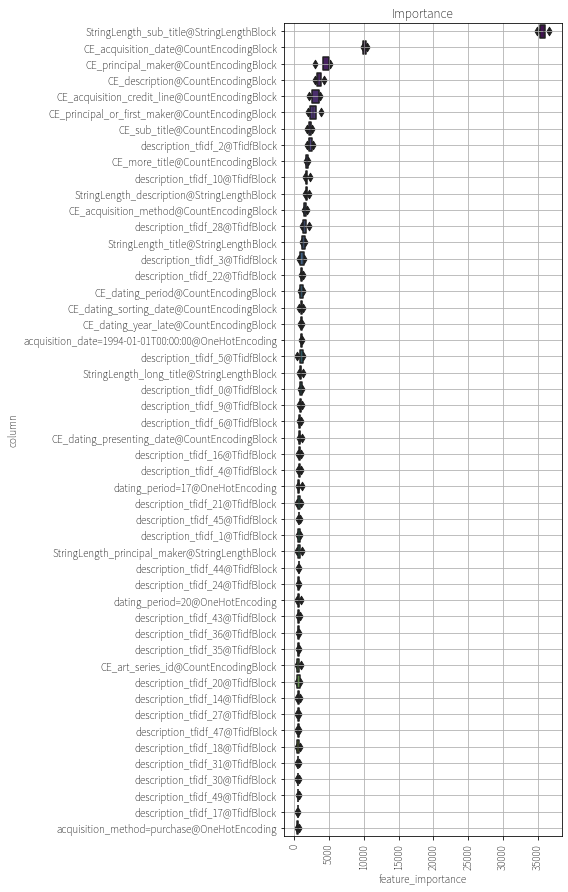

In [100]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

In [102]:
test_feat_df = run_blocks(input_df=test_df, blocks=feature_blocks, test=True)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	- <__main__.OneHotEncoding object at 0x7fe51008d690> 0.005[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d6d0> 0.002[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d710> 0.001[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d650> 0.002[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d550> 0.002[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d4d0> 0.002[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d490> 0.003[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d450> 0.002[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d410> 0.002[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d510> 0.003[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d3d0> 0.002[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d390> 0.003[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d350> 0.002[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d310> 0.001[s]
	- <__main__.OneHotEncoding object at 0x7fe51008d2d0> 0.

/home/penguin/.conda/lib/python3.7/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/penguin/.conda/lib/python3.7/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


	- <__main__.TfidfBlock object at 0x7fe512b3ddd0> 2.085[s]
run test=True 2.277[s]


In [103]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, '0002__submission.csv'), index=False)

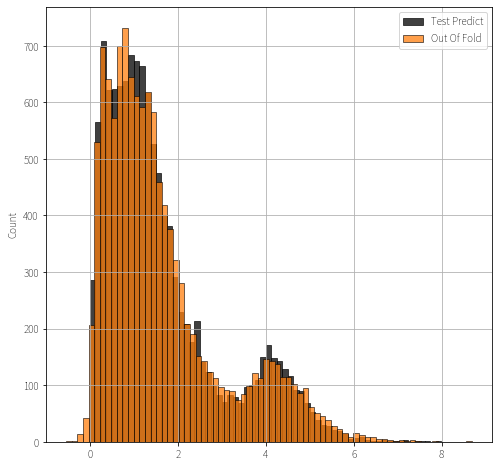

In [104]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

## 質問に答えるコーナー

> EDA：「データの偏り方」は大事な着眼点かと思うのですが、（主にコンペの外の現実世界では）未知のデータに対してどう向き合うものなのでしょうか

未知データへの対応について。現実問題ではコンペで言うところのテストデータはあったりなかったりしますが、おそらく質問では無いものが想定されていると思いますのでその前提でお話します。

まず予測するであろうデータがどういうものかを想定するところからスタートします。

基本的にすべてのデータはログデータですので、データの生成時刻が特定の時刻より前のデータを参照元とすると、過去と未来の状況を作り出せます。この状況でデータの乖離度合いを調べて、ある程度系が定常と言えるか或いは時系列で変動するとみなす必要があるかを検討します。

この検討時にコンペティションでの train / test の分布の違いを検討する際のノウハウが生きてきます。(そもそもコンペに出ていないと、こうやって分布が変わることを検討する重要性についてそこまで感じないのではないでしょうか)

もちろん本当の未来の情報はやってみないとわからないので、検討しても未来のデータがその検討等は違う動きをする場合はあります。たとえばリテール(小売)ですとコロナまえとあととではユーザの購買傾向は大きく変動していて、これはコロナまえに想定することはほぼ不可能でしょう。

このような性能悪化時には「予測性能が悪いのはなんでか?」という問を立てて考える必要があります。このとき、どの特徴量が悪さをしているか(傾向が変わっているか・その度合いはどのぐらいか)などを検討をしますが、こういうときにスコア乖離とデータの分布の関係性に関する感覚やノウハウがあるととても便利です。

> 分析コンペでCV/LBの乖離からデータの偏りを分析する際のノウハウは、現実世界で未知のデータに予測モデルを適用しようとする際に役立ちますか？

以上のことから、役にたつと考えています。

> コンペではCVのスコアに対してLBのスコアというフィードバックが得られますが、未知のデータからはフィードバックを得ようがないように思えるので・・・。cv後にy_testで再度学習するのでしょうが、y_valid, y_test, 未知のデータ全て分布が違っていたらどうするのかと素人目線には思ってしまいます

「コンペではCVのスコアに対してLBのスコアというフィードバックが得られますが」とありますが、コンペでもLBのスコアのフィードバックを正とすると private でスコアがでずに勝てないので、基本的に実装の確認程度のフィードバックしかもらってだめという立場です。

> 回帰問題のモデルのアンサンブルをする際の注意点等あれば

得にはないです。

しいていうならば「アンサンブルをするな」という注意はあります。これはアンサンブルは基本的に最後のひと押しぐらいしかならないことが多く、大抵の場合はよい特徴量を作る・すなわちデータをきちんと理解することのほうが重要であるからです。

> notebook形式のソースコード管理やパラメータ・実験結果の管理をどうされているのかについても、取り上げていただけるとありがたいです。

notebook で完結するように書くことでしょうか。コードが汚くなることを恐れずにベタに書くことが再現性を担保するためのもっとも手軽な方法かなと思います。
僕は基本的に実験は自分で作っているライブラリ `vivid` で書いていて、これは特徴量・モデル作成・可視化を一気通貫にやってかつ出力をすべて階層化して保存してくれるので、これをもって実験を管理しています。業務の分析は最後必ず `.py` へ落とし込むので、git のバージョン管理で結果の再現性は取るようにしています。

In [ ]:
# たとえばこんな感じで実行したら notebook をコピーするとかもいいかも
import shutil

shutil.copy('./[講座2] EDA・モデルの改善.ipynb', OUTPUT_DIR)

# まとめて zipfile 化するという手もある
shutil.make_archive(os.path.join(os.path.dirname(OUTPUT_DIR), 'output'), 'zip', OUTPUT_DIR)